## install modules

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz
import os

In [2]:
%%script echo skipping

os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

skipping


## code

In [3]:
import torch
from PIL import Image
from torchvision import tv_tensors
# import fiftyone.utils.coco as fouc
from torchvision.io import read_image, ImageReadMode
import json
from torchvision.transforms.v2 import functional as F

class MapillaryDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms, annotations_path, classes=None):
        self.root = root
        self.img_dir = os.path.join(root, "images")
        self.transforms = transforms
        
        with open(annotations_path) as json_file:
            self.coco_annotations = json.load(json_file)

        # self.images = self.coco_annotations['images']
        # Filter images with bounding boxes
        self.images = [img for img in self.coco_annotations['images'] 
                       if any(ann['image_id'] == img['id'] and 'bbox' in ann 
                              for ann in self.coco_annotations['annotations'])]

        if classes:
            self.classes = classes
        else:
            self.classes = [category['name'] for category in self.coco_annotations['categories']]
            
        if self.classes[0] != "background":
            self.classes = ["background"] + self.classes

        self.material_classes = {'Unknown':0, 'Masonry':1, 'Wood':2, 'Steel':3, 'Concrete':4}
        self.material_classes_inverse = {v: k for k, v in self.material_classes.items()}

        

    def __getitem__(self, idx):
        img_id = self.images[idx]['id']
        img_path = os.path.join(self.img_dir, self.images[idx]['file_name'])
        
        # load images and masks
        # img_path = os.path.join(self.root, "images", self.imgs[idx])
        img = read_image(img_path)

         # Get annotations for this image
        annotations = [ann for ann in self.coco_annotations['annotations'] if ann['image_id'] == img_id]

        # Extract bounding boxes, labels, etc.
        boxes = [ann['bbox'] for ann in annotations]
        labels = [ann['category_id'] for ann in annotations]
        area = [ann['area'] for ann in annotations]
        material = [self.material_classes[ann['attributes']['material']] for ann in annotations]

        # area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        num_objs = len(labels)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        # convert boxes to right format
        boxes_xyxy = [[x, y, x + w, y + h] for x, y, w, h in boxes]

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes_xyxy, format="XYXY", canvas_size=F.get_size(img))
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        target["image_id"] = img_id
        target["area"] = torch.as_tensor(area, dtype=torch.float32)
        target["iscrowd"] = iscrowd
        target["attributes"] = torch.as_tensor(material, dtype=torch.int64)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.images)

Future exception was never retrieved
future: <Future finished exception=BrokenPipeError(32, 'Broken pipe')>
Traceback (most recent call last):
  File "/home/zhiyi/miniconda3/envs/frcnn2/lib/python3.10/asyncio/unix_events.py", line 676, in write
    n = os.write(self._fileno, data)
BrokenPipeError: [Errno 32] Broken pipe


In [4]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        # transforms.append(T.RandomRotation(30))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    # transforms.append(T.Resize((256,256)))
    return T.Compose(transforms)

In [5]:
from torch.utils.data import DataLoader
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import math
import sys

import utils # downloaded from github earlier

# image_transforms = transforms.Compose([transforms.ToTensor()])
# image_transforms = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
# train_dataset = FiftyOneTorchDataset(train_dataset_view, transforms=image_transforms, classes=classes_used)
# validation_dataset = FiftyOneTorchDataset(validation_dataset_view, transforms=image_transforms, classes=classes_used)

classes_used = ['building'] # figure out if i can auto retrieve this from the dataset later

raw_dataset = MapillaryDataset('data/mapillary', get_transform(train=False), 'data/mapillary/annotations/train_v2.json')
full_dataset = MapillaryDataset('data/mapillary', get_transform(train=True), 'data/mapillary/annotations/train_v2.json')
dataset_size = len(full_dataset)
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)
validation_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=utils.collate_fn)
# validation_dataset = FiftyOneTorchDataset(validation_dataset_view, transforms=get_transform(train=False), classes=classes_used)

# Define the ratio for splitting (e.g., 80% train, 20% validation)
# train_ratio = 0.8
# total_samples = len(torch_dataset)
# train_size = int(train_ratio * total_samples)
# print("train_size:", train_size)
# validation_size = total_samples - train_size
# print("validation_size:", validation_size)

# # Use random_split to create training and validation datasets
# train_dataset, validation_dataset = random_split(torch_dataset, [train_size, validation_size])

# # Create dataloaders for both the training and validation sets
# train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)
# validation_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=utils.collate_fn)
# validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False, collate_fn=utils.collate_fn)


In [6]:
with open('data/mapillary/annotations/train.json') as f:
    coco_annotations = json.load(f)

#print(coco_annotations)
#print(coco_annotations['annotations'])
#print(coco_annotations['images'])
img_id = 1
annotations = [ann for ann in coco_annotations['annotations'] if ann['image_id'] == img_id]
print(annotations)

[{'id': 1, 'image_id': 1, 'category_id': 1, 'segmentation': [], 'area': 1471479.4334999998, 'bbox': [864.97, 632.09, 2141.05, 687.27], 'iscrowd': 0, 'attributes': {'category': 'Unknown', 'occupancy_group': 'Unknown', 'occupancy_type': 'Unknown', 'no_floors': 'Unknown', 'basement': False, 'material': 'Unknown', 'roof_shape': 'Unknown', 'roof_covers': 'Unknown', 'shutters': False, 'window_area': 'Unknown', 'occluded': False, 'rotation': 0.0}}]


In [7]:
# calculate attribute weights

from collections import Counter

counter = Counter()
for i in range(len(train_dataset)):
    attrib_tensor = train_dataset[i][1]['attributes']
    counter.update(attrib_tensor.view(-1).tolist())

print(counter)

weights = [0]*len(full_dataset.material_classes)
total_v = sum(counter.values())
for k,v in counter.items():
    weights[k] = total_v/v

weights = torch.as_tensor(weights, dtype=torch.float32)
print(weights)
weights = weights/weights.max() # to account for first 0/ should modify it further to fix this tbh
GLOBAL_ATTRIBUTE_WEIGHTS = weights

print(GLOBAL_ATTRIBUTE_WEIGHTS)

print(GLOBAL_ATTRIBUTE_WEIGHTS.dtype)
#GLOBAL_ATTRIBUTE_WEIGHTS[4] *= 10
GLOBAL_ATTRIBUTE_WEIGHTS[0] = weights[1:].min()
# GLOBAL_ATTRIBUTE_WEIGHTS *= 3
print(GLOBAL_ATTRIBUTE_WEIGHTS)
print(GLOBAL_ATTRIBUTE_WEIGHTS.dtype)

Counter({4: 1044, 1: 119, 3: 32, 2: 22})
tensor([ 0.0000, 10.2269, 55.3182, 38.0312,  1.1657])
tensor([0.0000, 0.1849, 1.0000, 0.6875, 0.0211])
torch.float32
tensor([0.0211, 0.1849, 1.0000, 0.6875, 0.0211])
torch.float32


In [8]:
a = torch.tensor([[0.1, 0.2, 0.5], [0.2, 0.2, 0.5]], dtype=torch.float32)
b = torch.tensor([1, 1], dtype=torch.int64)
c = torch.tensor([5, 10, 0.01], dtype=torch.float32)

print(torch.nn.functional.cross_entropy(a, b, weight=c, reduction='sum')/2)
print(torch.nn.functional.cross_entropy(a, b, weight=c, reduction='mean'))

tensor(11.9451)
tensor(1.1945)


8


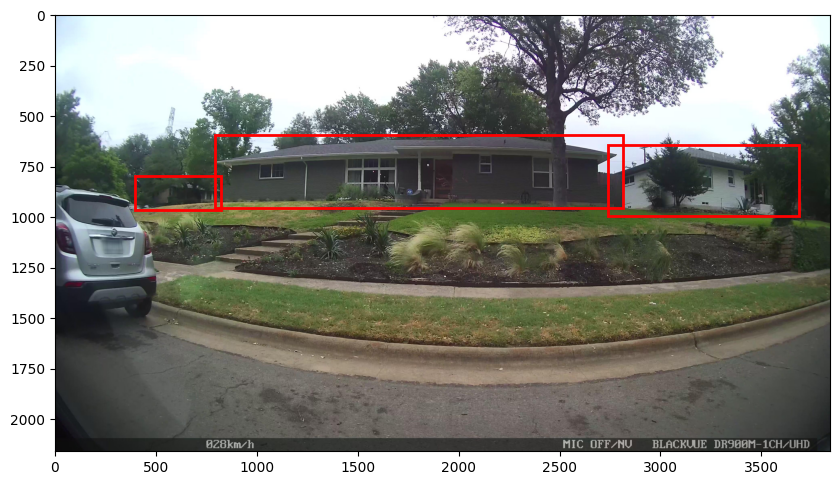

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

tensor_image, first_target = raw_dataset[6]
print(raw_dataset[6][1]['image_id'])

tensor_image = tensor_image.permute(1, 2, 0)
numpy_image = tensor_image.numpy()

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(numpy_image)

ax = plt.gca()

for box in first_target["boxes"]:
    xmin, ymin, xmax, ymax = box
    width, height = xmax - xmin, ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [10]:
from torch.utils.tensorboard import SummaryWriter

write = True

if write:
    writer = SummaryWriter('runs/frcnn_mapillary_base2')


In [11]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image

def eval_image(model, epoch, save=True, index=None, attrib=False):

    if index == None:
        index = val_dataset[0][1]['image_id']

    target = None # problem is full_dataset has transform where train=True, so some targets are randomly flipped
    for _, t in raw_dataset:
        if t['image_id'] == index:
            target = t
            break
    else:
        print('index does not exist in dataset')
        return    
    target_boxes = target['boxes']
    target_labels = [f"{full_dataset.material_classes_inverse[int(attrib_label)]}" for attrib_label in target['attributes']]

    image = read_image(f'data/mapillary/images/image_{index}.jpg')
    
    eval_transform = get_transform(train=False)
    
    model.eval()
    with torch.no_grad():
        x = eval_transform(image)
        # convert RGBA -> RGB and move to device
        x = x[:3, ...].to(device)
        predictions = model([x, ])
        pred = predictions[0]

    score_threshold = 0.6

    for i, score in enumerate(pred['scores']):
        if score<score_threshold:
            for key, value in pred.items():
                pred[key] = pred[key][:i]
            break
            
    
    # print(pred) 
    
    
    # image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
    image = image[:3, ...]
    
    pred_boxes = pred["boxes"].long()
    if attrib:
        pred_labels = [f"{label}: {score:.3f}\n{full_dataset.material_classes_inverse[int(attrib)]}" for label, score, attrib in zip(pred["labels"], pred["scores"], pred['attributes'])] # TODO FIGURE OUT HOW TO MAP THE LABEL NUMBER BACK TO TEXT
        pred_attributes = pred['attributes']
        print(pred_attributes)
    else:
        pred_labels = [f"{label}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])] # TODO FIGURE OUT HOW TO MAP THE LABEL NUMBER BACK TO TEXT
    print(pred["labels"])
    print(pred["scores"])
    output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red", font='Roboto-Regular.ttf', font_size=64)

    output_image = draw_bounding_boxes(output_image, target_boxes, target_labels, colors="green", font='Roboto-Regular.ttf', font_size=64)
    
    # for label, box in zip(pred_labels, pred_boxes):
    #     print("label:", label, "box:", box)
    
    plt.figure(figsize=(24, 24))
    plt.imshow(output_image.permute(1, 2, 0))
    if save:
        plt.savefig(f"eval_image/epoch{epoch}.jpg", bbox_inches='tight', pad_inches=0)  # Specify the path and filename
    else:
        plt.show()
    plt.close() 

In [12]:
import custom_faster_rcnn as c_frcnn
from torchvision.models.detection._utils import overwrite_eps
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

if not os.path.isfile('fasterrcnn_resnet50_fpn_coco-258fb6c6.pth'):
    os.system('wget https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth')

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

custom = False

if custom:

    # work out when's the right time to send this to device. images and targets are sent to device in train_one_epoch. so should i pass in to train_one_epoch, then modify forward of  CustomFasterRCNN to handle that input as well
    GLOBAL_ATTRIBUTE_WEIGHTS = GLOBAL_ATTRIBUTE_WEIGHTS.to(device)

    model = c_frcnn.custom_fasterrcnn_resnet50_fpn(num_classes=11, num_attribs=5, attribute_weights=GLOBAL_ATTRIBUTE_WEIGHTS)#weights=torchvision.models.detection.faster_rcnn.FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
    pretrained_dict = torch.load('fasterrcnn_resnet50_fpn_coco-258fb6c6.pth')  # Load the pretrained model weights
    model_dict = model.state_dict()
    
    # Filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and model_dict[k].shape == v.shape}
    model_dict.update(pretrained_dict) 
    model.load_state_dict(model_dict)
    overwrite_eps(model, 0.0)

    model.to(device)
     

else:

    # CREATE BASE_MODEL
   
    #model = fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.faster_rcnn.FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    
    model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=1024,num_classes=11)
    
    model.to(device)
    

# if torch.cuda.is_available():
#     # If a GPU is available, move the model to the GPU
#     model = model.cuda()

eval_image(model, -1)


tensor([], device='cuda:0', dtype=torch.int64)
tensor([], device='cuda:0')


/home/zhiyi/miniconda3/envs/frcnn2/lib/python3.10/site-packages/torchvision/utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


In [13]:
import engine

num_epochs = 10

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# figure out why class_logits is still rly long

if custom:

    for epoch in range(num_epochs):
        # train the model for one epoch
        train_metrics = c_frcnn.train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=500)
    
        
        
        # update the learning rate
        lr_scheduler.step()
        
        # evaluate on the test dataset
        validation_metrics = c_frcnn.evaluate(model, validation_dataloader, device=device)
        
        if write:
            writer.add_scalar('Loss/train', train_metrics.loss.global_avg, epoch)
            writer.add_scalar('mAP/validation', validation_metrics.coco_eval['bbox'].stats[0], epoch)
        
        # save image of example
        eval_image(model, epoch)

else:
    
    for epoch in range(num_epochs):
        # train the model for one epoch
        train_metrics=engine.train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=250)
        
        
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        validation_metrics=engine.evaluate(model, validation_dataloader, device=device)

        if write:
            writer.add_scalar('Loss/train', train_metrics.loss.global_avg, epoch)
            writer.add_scalar('mAP/validation', validation_metrics.coco_eval['bbox'].stats[0], epoch)
    
        eval_image(model, epoch)

        # Additional information
        checkpoint_file = f"./checkpoints_stop/model_{epoch}.pt"
        
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': train_metrics.loss.global_avg
                    }, checkpoint_file)

Epoch: [0]  [  0/121]  eta: 0:01:47  lr: 0.000047  loss: 3.4957 (3.4957)  loss_classifier: 3.0982 (3.0982)  loss_box_reg: 0.1754 (0.1754)  loss_objectness: 0.1888 (0.1888)  loss_rpn_box_reg: 0.0333 (0.0333)  time: 0.8857  data: 0.0595  max mem: 4873
Epoch: [0]  [120/121]  eta: 0:00:00  lr: 0.005000  loss: 0.3660 (0.6643)  loss_classifier: 0.1227 (0.3785)  loss_box_reg: 0.1967 (0.2335)  loss_objectness: 0.0100 (0.0339)  loss_rpn_box_reg: 0.0119 (0.0184)  time: 0.7649  data: 0.0475  max mem: 5113
Epoch: [0] Total time: 0:01:35 (0.7891 s / it)
creating index...
index created!
Test:  [ 0/31]  eta: 0:00:11  model_time: 0.3069 (0.3069)  evaluator_time: 0.0043 (0.0043)  time: 0.3560  data: 0.0293  max mem: 5113
Test:  [30/31]  eta: 0:00:00  model_time: 0.3044 (0.3127)  evaluator_time: 0.0043 (0.0044)  time: 0.3974  data: 0.0583  max mem: 5113
Test: Total time: 0:00:12 (0.3925 s / it)
Averaged stats: model_time: 0.3044 (0.3127)  evaluator_time: 0.0043 (0.0044)
Accumulating evaluation results..

In [14]:
if write:
    writer.flush()
    writer.close()

# print(train_metrics.loss.avg)
# print(validation_metrics.coco_eval['bbox'].stats[0])

In [ ]:
# val_index = val_dataset[0][1]['image_id']

# # target: Counter({4: 1045, 1: 120, 3: 36, 2: 27})

# eval_image(model, 'test', save=False, index=val_index)

for _, t in val_dataset:
    val_index = t['image_id']
    eval_image(model, 'test', save=False, index=val_index)

In [ ]:
# END

# print(train_metrics.loss.global_avg)
shutdown = False
if shutdown:
    os.system('shutdown -h now')

# import os



In [ ]:
# END

In [ ]:
%%script echo skipping

# plot bbox from model
#file = "/home/zhiyi/fiftyone/open-images-v7/validation/data/0f426802e98a8964.jpg"
#file = "/home/zhiyi/fiftyone/open-images-v7/train/data/0ca0f9c12dde03e0.jpg"
file = '/home/zhiyi/fiftyone/coco-2017/train/data/000000000064.jpg'
image = read_image(file)
model.eval()
with torch.no_grad():
    eval_transform = get_transform(train=False)
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

# print(pred)

for key, value in pred.items():
    pred[key] = pred[key][:1]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"cat: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

for label, box in zip(pred_labels, pred_boxes):
    print("label:", label, "box:", box)

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [ ]:
%%script echo skipping
#TARGET BBOX

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot_image_with_boxes(dataset, image_file_name):
    # Find the sample in the dataset
    sample = next((s for s in dataset.samples if s.filepath == image_file_name), None)
    if sample is None:
        print(f"Image {image_file_name} not found in the dataset.")
        return

    # Load the image
    img = Image.open(sample.filepath)
    img_width, img_height = img.size
    
    # Set up the plot
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    # Plot each bounding box
    detections = sample[dataset.gt_field].detections
    for det in detections:
        # Scale bounding box coordinates to image size
        x, y, width, height = det.bounding_box
        x, width = x * img_width, width * img_width
        y, height = y * img_height, height * img_height

        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, det.label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

plot_image_with_boxes(train_dataset, "/home/zhiyi/fiftyone/coco-2017/train/data/000000000064.jpg")